In [3]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, roc_auc_score

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
from torch.cuda.amp import autocast, GradScaler
from torch.optim.lr_scheduler import ReduceLROnPlateau
from PIL import Image

import warnings
warnings.filterwarnings("ignore")

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

In [6]:
# Check for GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


In [7]:
# Image transformations
img_size = 224  # EfficientNet recommended size

# Data augmentation for training
train_transforms = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Validation/test transformations
val_transforms = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [8]:
# Custom Dataset class for multimodal data
class SkinLesionDataset(Dataset):
    def __init__(self, dataframe, img_dir, transform=None, important_features=None):
        self.dataframe = dataframe
        self.img_dir = img_dir
        self.transform = transform

        # Extract the target variable
        self.y = self.dataframe['RESULT'].values

        # Define important textual features
        self.important_features = important_features if important_features else [
            'itch', 'grew', 'hurt', 'changed', 'bleed', 'fitzpatrick', 'age'
        ]

        # Select all features except RESULT and img_id
        self.all_features = [col for col in self.dataframe.columns
                            if col not in ['RESULT', 'img_id']]

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        # Get image file name
        img_name = self.dataframe.iloc[idx]['img_id']
        img_path = os.path.join(self.img_dir, img_name)

        # Load and transform image
        try:
            image = Image.open(img_path).convert('RGB')
            if self.transform:
                image = self.transform(image)
        except Exception as e:
            print(f"Error loading image {img_name}: {e}")
            # Return a blank image in case of error
            image = torch.zeros(3, img_size, img_size)

        # Get important features (will be given higher weight in the model)
        important_features = torch.tensor([
            self.dataframe.iloc[idx][feat] for feat in self.important_features
            if feat in self.dataframe.columns
        ], dtype=torch.float32)

        # Get all other features
        other_features = torch.tensor([
            self.dataframe.iloc[idx][feat] for feat in self.all_features
            if feat not in self.important_features and feat in self.dataframe.columns
        ], dtype=torch.float32)

        # Get target
        target = torch.tensor(self.dataframe.iloc[idx]['RESULT'], dtype=torch.float32)

        return {
            'image': image,
            'important_features': important_features,
            'other_features': other_features,
            'target': target
        }

In [9]:
# Multimodal CNN model
class SkinCancerModel(nn.Module):
    def __init__(self, num_important_features, num_other_features):
        super(SkinCancerModel, self).__init__()

        # Image feature extractor using EfficientNet
        self.efficientnet = models.efficientnet_v2_s(weights='IMAGENET1K_V1')
        eff_out_features = self.efficientnet.classifier[1].in_features
        self.efficientnet.classifier = nn.Identity()  # Remove classifier

        # Important feature processing with higher weight
        self.important_fc = nn.Sequential(
            nn.Linear(num_important_features, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 32),
            nn.ReLU()
        )

        # Other feature processing
        self.other_fc = nn.Sequential(
            nn.Linear(num_other_features, 32),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(32, 16),
            nn.ReLU()
        )

        # Fusion layer
        self.fusion = nn.Sequential(
            nn.Linear(eff_out_features + 32 + 16, 256),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(256, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 1)
        )

        # Attention mechanism for image features (to give more importance)
        self.attention = nn.Sequential(
            nn.Linear(eff_out_features, eff_out_features),
            nn.Sigmoid()
        )

    def forward(self, image, important_features, other_features):
        # Extract image features
        img_features = self.efficientnet(image)

        # Apply attention to image features
        attention_weights = self.attention(img_features)
        img_features = img_features * attention_weights

        # Process important features
        imp_features = self.important_fc(important_features)

        # Process other features
        other_feats = self.other_fc(other_features)

        # Concatenate all features
        combined = torch.cat((img_features, imp_features, other_feats), dim=1)

        # Final prediction
        output = self.fusion(combined)
        return output

In [10]:
# Training function
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=25):
    # Lists to store metrics
    train_losses = []
    val_losses = []
    val_accuracies = []

    # Best model tracking
    best_val_loss = float('inf')
    best_model_wts = None

    # Early stopping parameters
    patience = 13
    early_stop_counter = 0

    # Gradient scaler for mixed precision training
    scaler = GradScaler()

    for epoch in range(num_epochs):
        print(f'\nEpoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        # Training phase
        model.train()
        running_loss = 0.0

        for batch in train_loader:
            images = batch['image'].to(device)
            important_features = batch['important_features'].to(device)
            other_features = batch['other_features'].to(device)
            targets = batch['target'].to(device).unsqueeze(1)

            # Zero gradients
            optimizer.zero_grad()

            # Mixed precision forward pass
            with autocast():
                outputs = model(images, important_features, other_features)
                loss = criterion(outputs, targets)

            # Backpropagation with gradient scaling
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            running_loss += loss.item() * images.size(0)

        epoch_train_loss = running_loss / len(train_loader.dataset)
        train_losses.append(epoch_train_loss)

        # Validation phase
        model.eval()
        running_loss = 0.0
        all_preds = []
        all_targets = []

        with torch.no_grad():
            for batch in val_loader:
                images = batch['image'].to(device)
                important_features = batch['important_features'].to(device)
                other_features = batch['other_features'].to(device)
                targets = batch['target'].to(device).unsqueeze(1)

                outputs = model(images, important_features, other_features)
                loss = criterion(outputs, targets)

                running_loss += loss.item() * images.size(0)

                # Convert outputs to predictions
                preds = (torch.sigmoid(outputs) > 0.5).float()

                all_preds.extend(preds.cpu().numpy())
                all_targets.extend(targets.cpu().numpy())

        # Calculate validation metrics
        epoch_val_loss = running_loss / len(val_loader.dataset)
        val_losses.append(epoch_val_loss)

        all_preds = np.array(all_preds)
        all_targets = np.array(all_targets)

        accuracy = (all_preds == all_targets).mean() * 100
        val_accuracies.append(accuracy)

        print(f'Train Loss: {epoch_train_loss:.4f}')
        print(f'Val Loss: {epoch_val_loss:.4f}, Val Accuracy: {accuracy:.2f}%')

        # Learning rate adjustment
        scheduler.step(epoch_val_loss)

        # Save best model
        if epoch_val_loss < best_val_loss:
            best_val_loss = epoch_val_loss
            best_model_wts = model.state_dict().copy()
            early_stop_counter = 0
        else:
            early_stop_counter += 1

        # Early stopping
        if early_stop_counter >= patience:
            print(f'Early stopping triggered after {epoch+1} epochs')
            break

    # Load best model weights
    model.load_state_dict(best_model_wts)

    return model, train_losses, val_losses, val_accuracies

In [11]:
# Function to evaluate model and plot results
def evaluate_model(model, test_loader, criterion):
    model.eval()
    running_loss = 0.0
    all_preds = []
    all_targets = []
    all_probs = []

    with torch.no_grad():
        for batch in test_loader:
            images = batch['image'].to(device)
            important_features = batch['important_features'].to(device)
            other_features = batch['other_features'].to(device)
            targets = batch['target'].to(device).unsqueeze(1)

            outputs = model(images, important_features, other_features)
            loss = criterion(outputs, targets)

            running_loss += loss.item() * images.size(0)

            # Get probabilities and predictions
            probs = torch.sigmoid(outputs)
            preds = (probs > 0.5).float()

            all_probs.extend(probs.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())

    # Calculate test metrics
    test_loss = running_loss / len(test_loader.dataset)
    all_probs = np.array(all_probs)
    all_preds = np.array(all_preds)
    all_targets = np.array(all_targets)

    # Print metrics
    print(f'Test Loss: {test_loss:.4f}')
    print('\nClassification Report:')
    print(classification_report(all_targets, all_preds))

    # Calculate and plot confusion matrix
    cm = confusion_matrix(all_targets, all_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Non-Cancer', 'Cancer'],
                yticklabels=['Non-Cancer', 'Cancer'])
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.tight_layout()
    plt.savefig('confusion_matrix.png')
    plt.show()

    # Plot ROC curve
    fpr, tpr, _ = roc_curve(all_targets, all_probs)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.savefig('roc_curve.png')
    plt.show()

    return test_loss, all_preds, all_targets, all_probs

In [12]:
# Main execution
def main():
    # Load data
    data_path = '/content/drive/MyDrive/Dataset/metadata.csv'  # Update this path
    img_dir = '/content/drive/MyDrive/Dataset/Images'  # Update this path to your image directory

    df = pd.read_csv(data_path)

    # Define important features
    important_features = ['itch', 'grew', 'hurt', 'changed', 'bleed', 'fitzpatrick', 'age']

    # Split data
    train_df, temp_df = train_test_split(df, test_size=0.3, random_state=42, stratify=df['RESULT'])
    val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42, stratify=temp_df['RESULT'])

    print(f"Training set: {len(train_df)} samples")
    print(f"Validation set: {len(val_df)} samples")
    print(f"Test set: {len(test_df)} samples")

    # Create datasets
    train_dataset = SkinLesionDataset(train_df, img_dir, transform=train_transforms,
                                      important_features=important_features)
    val_dataset = SkinLesionDataset(val_df, img_dir, transform=val_transforms,
                                    important_features=important_features)
    test_dataset = SkinLesionDataset(test_df, img_dir, transform=val_transforms,
                                     important_features=important_features)

    # Create data loaders
    batch_size = 16
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

    # Check sample sizes
    sample_batch = next(iter(train_loader))
    print(f"Image shape: {sample_batch['image'].shape}")
    print(f"Important features shape: {sample_batch['important_features'].shape}")
    print(f"Other features shape: {sample_batch['other_features'].shape}")

    # Initialize model
    num_important_features = sample_batch['important_features'].shape[1]
    num_other_features = sample_batch['other_features'].shape[1]

    model = SkinCancerModel(num_important_features, num_other_features).to(device)

    # Define loss function and optimizer
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-5)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)

    # Train model
    model, train_losses, val_losses, val_accuracies = train_model(
        model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=30
    )

    # Save model
    torch.save(model, 'skin_cancer_model.pt')

    # Plot training history
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.title('Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()

    plt.tight_layout()
    plt.savefig('training_history.png')
    plt.show()

    # Evaluate on test set
    test_loss, test_preds, test_targets, test_probs = evaluate_model(model, test_loader, criterion)

    # Function to predict on a new sample
    def predict_sample(model, image_path, patient_data):
        """
        Predict cancer probability for a new patient

        Parameters:
        - model: trained model
        - image_path: path to the lesion image
        - patient_data: dictionary with patient features

        Returns:
        - probability of cancer
        - binary prediction (0 or 1)
        """
        model.eval()

        # Process image
        image = Image.open(image_path).convert('RGB')
        image = val_transforms(image).unsqueeze(0).to(device)

        # Process important features
        important_features = torch.tensor([
            patient_data.get(feat, 0) for feat in important_features
        ], dtype=torch.float32).unsqueeze(0).to(device)

        # Process other features (assuming we have all features defined)
        other_features = torch.tensor([
            patient_data.get(feat, 0) for feat in other_feature_list  # Define this list as needed
        ], dtype=torch.float32).unsqueeze(0).to(device)

        with torch.no_grad():
            output = model(image, important_features, other_features)
            prob = torch.sigmoid(output).item()
            pred = 1 if prob > 0.5 else 0

        return prob, pred

    print("Model training and evaluation complete!")

Training set: 1608 samples
Validation set: 345 samples
Test set: 345 samples
Image shape: torch.Size([16, 3, 224, 224])
Important features shape: torch.Size([16, 7])
Other features shape: torch.Size([16, 25])


Downloading: "https://download.pytorch.org/models/efficientnet_v2_s-dd5fe13b.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_v2_s-dd5fe13b.pth
100%|██████████| 82.7M/82.7M [00:00<00:00, 163MB/s]



Epoch 1/30
----------
Train Loss: 0.6436
Val Loss: 0.5416, Val Accuracy: 77.10%

Epoch 2/30
----------
Train Loss: 0.4555
Val Loss: 0.4156, Val Accuracy: 81.74%

Epoch 3/30
----------
Train Loss: 0.3866
Val Loss: 0.4552, Val Accuracy: 80.87%

Epoch 4/30
----------
Train Loss: 0.3260
Val Loss: 0.4228, Val Accuracy: 84.93%

Epoch 5/30
----------
Train Loss: 0.2574
Val Loss: 0.3848, Val Accuracy: 87.54%

Epoch 6/30
----------
Train Loss: 0.2392
Val Loss: 0.3298, Val Accuracy: 88.41%

Epoch 7/30
----------
Train Loss: 0.1841
Val Loss: 0.3701, Val Accuracy: 87.54%

Epoch 8/30
----------
Train Loss: 0.1562
Val Loss: 0.3682, Val Accuracy: 86.38%

Epoch 9/30
----------
Train Loss: 0.1679
Val Loss: 0.3720, Val Accuracy: 86.38%

Epoch 10/30
----------
Train Loss: 0.1235
Val Loss: 0.4233, Val Accuracy: 87.25%

Epoch 11/30
----------
Train Loss: 0.1057
Val Loss: 0.4151, Val Accuracy: 89.28%

Epoch 12/30
----------
Train Loss: 0.1028
Val Loss: 0.4553, Val Accuracy: 84.93%

Epoch 13/30
----------
T

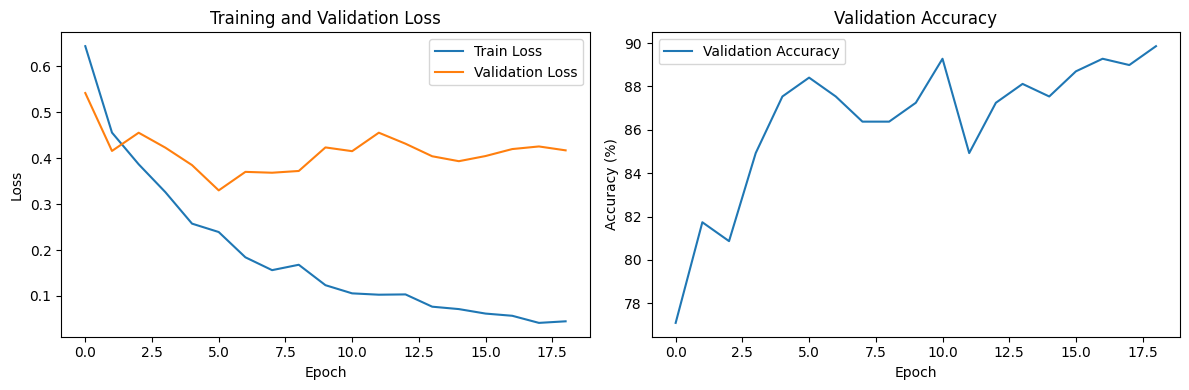

Test Loss: 0.5137

Classification Report:
              precision    recall  f1-score   support

         0.0       0.84      0.87      0.86       182
         1.0       0.85      0.82      0.83       163

    accuracy                           0.85       345
   macro avg       0.85      0.84      0.85       345
weighted avg       0.85      0.85      0.85       345



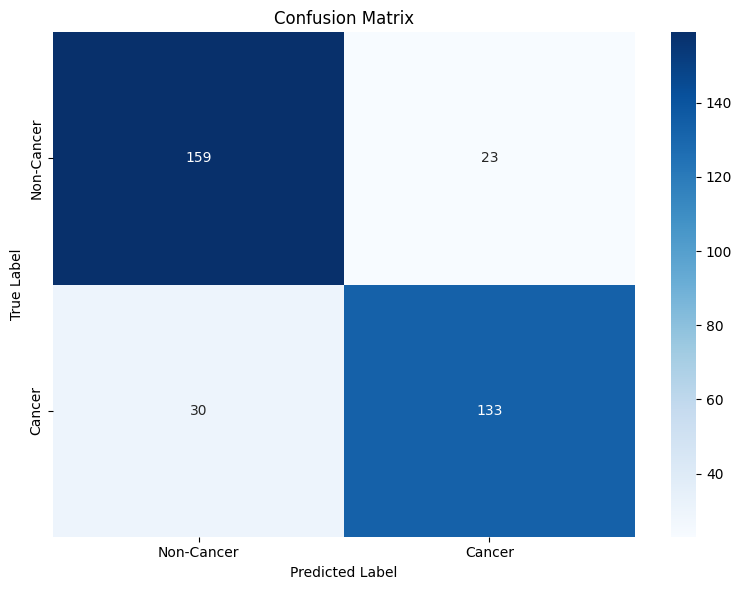

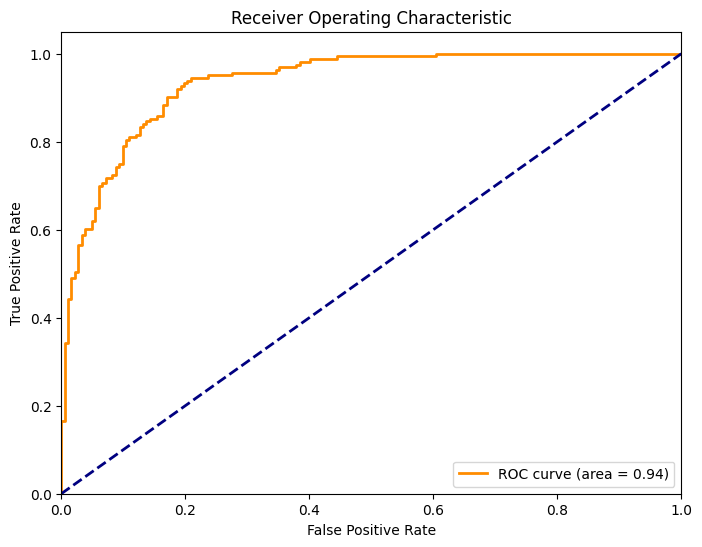

Model training and evaluation complete!


In [13]:
main()